# Chains in LangChain

## <요약>

* LLMChain
* Sequential Chains
  * langchain.chains.SimpleSequentialChain
  * langchain.chains.SequentialChain
* Router Chain
  * langchain.chains.router.MultiPromptChain
  * langchain.chains.router.llm_router.LLMRouterChain, 
  * langchain.chains.router.llm_router.RouterOutputParser

In [8]:
import sys
sys.path.append('./.env')

import warnings
warnings.filterwarnings('ignore')
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

import pandas as pd
df = pd.read_csv('Data.csv')
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\r\n,I loved this product. But they only seem to l...


In [31]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SimpleSequentialChain, SequentialChain

from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

llm = ChatOpenAI(temperature=0.9)

prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

chain = LLMChain(llm=llm, prompt=prompt) 

# llm과 prompt를 입력으로 받아 1장에서의 chat()이 아닌 LLMChain에서 run을 수행 합니다.
product = "Queen Size Sheet Set"
chain.run(product)

'Royal Comfort Sheets Co.'

## (1) SimpleSequentialChain

In [14]:
llm = ChatOpenAI(temperature=0.9)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two], verbose=True)

product = "Queen Size Sheet Set"
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
"Regal Linens"
Regal Linens offers luxurious and high-quality bedding and linens to elevate your bedroom decor and provide the ultimate comfort.

> Finished chain.


'Regal Linens offers luxurious and high-quality bedding and linens to elevate your bedroom decor and provide the ultimate comfort.'

## (2) SequentialChain

In [ ]:
"""
Review  -> English_Review -> summary    -> followup_message
        -> language                     ->
"""
llm = ChatOpenAI(temperature=0.9)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:" "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review" # output_key를 명시해준다.
                    )
print(chain_one)

second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:" "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )

# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )
print(chain_four)

In [18]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\r\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold, it's weird. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?",
 'summary': 'The reviewer finds the taste of this product to be mediocre, with the foam not holding well, leading them to question if it is an old batch or counterfeit.',
 'followup_message': "Je vous remercie pour votre avis honnête sur le produit. Nous sommes désolés d'apprendre que la saveur n'était pas à la hauteur de vos attentes et que la mousse ne tenait pas bien. Nous vous assurons que tous nos produits sont authentiques et nous prendrons des mesures pour garantir que la qualité soit maintenue à un niveau élevé. Nous apprécions vos commentaires et nous espérons avoir l'occasion de vous satisfaire pleinement à l'avenir."}

In [21]:
review = df.Review[2]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "This mattress had a small hole in the top of it (took forever to find where it was), and the patches that they provide did not work, maybe because it's the top of the mattress where it's kind of like fabric and a patch won't stick. Maybe I got unlucky with a defective mattress, but where's quality assurance for this company? That flat out should not happen. Emphasis on flat. Cause that's what the mattress was. Seriously horrible experience, ruined my friend's stay with me. Then they make you ship it back instead of just providing a refund, which is also super annoying to pack up an air mattress and take it to the UPS store. This company is the worst, and this mattress is the worst.",
 'English_Review': "This mattress had a small hole in the top of it (took forever to find where it was), and the patches that they provide did not work, maybe because it's the top of the mattress where it's kind of like fabric and a patch won't stick. Maybe I got unlucky with a defective mattre

## (3) Router Chain

In [22]:

physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. You are so good because you are able to break down \
hard problems into their component parts, answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration, forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. You are so good because you know how to solve a problem by \
describing the solution in imperative steps that a machine can easily interpret and you know how to \
choose a solution that has a good balance between time complexity and space complexity. 

Here is a question:
{input}"""

In [23]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]
llm = ChatOpenAI(temperature=0)

In [29]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain

destinations = [f"{p['name']} : {p['description']}" for p in prompt_infos]
print(destinations)
destinations_str = "\n".join(destinations)
print(destinations_str)

['physics : Good for answering questions about physics', 'math : Good for answering math questions', 'History : Good for answering history questions', 'computer science : Good for answering computer science questions']
physics : Good for answering questions about physics
math : Good for answering math questions
History : Good for answering history questions
computer science : Good for answering computer science questions


In [28]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a description of what the prompt is best suited for. \
You may also revise the original input if you think that revising it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [32]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser() # RouterOutputParser()??
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

chain = MultiPromptChain(router_chain=router_chain,
                         destination_chains=destination_chains,
                         default_chain=default_chain, 
                         verbose=True
                         )

In [33]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


'Black body radiation is the electromagnetic radiation emitted by a perfect absorber (or emitter) of all frequencies. A black body is an idealized physical body that absorbs all incident electromagnetic radiation, regardless of frequency or angle of incidence. As a result, it also emits radiation at a characteristic spectrum of wavelengths and intensities that depend only on its temperature. This spectrum is called black body radiation. The study of black body radiation was instrumental in the development of quantum mechanics and the understanding of the behavior of atoms and molecules.'

In [34]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'Thank you for the compliment! The answer to the question "what is 2 + 2" is 4.'

In [35]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
biology: {'input': 'Why does every cell in our body contain DNA?'}

ValueError: Received invalid destination chain name 'biology'

---

순서 체인
- 하나 출력의 결과가 다음의 입력으로 제공된다.

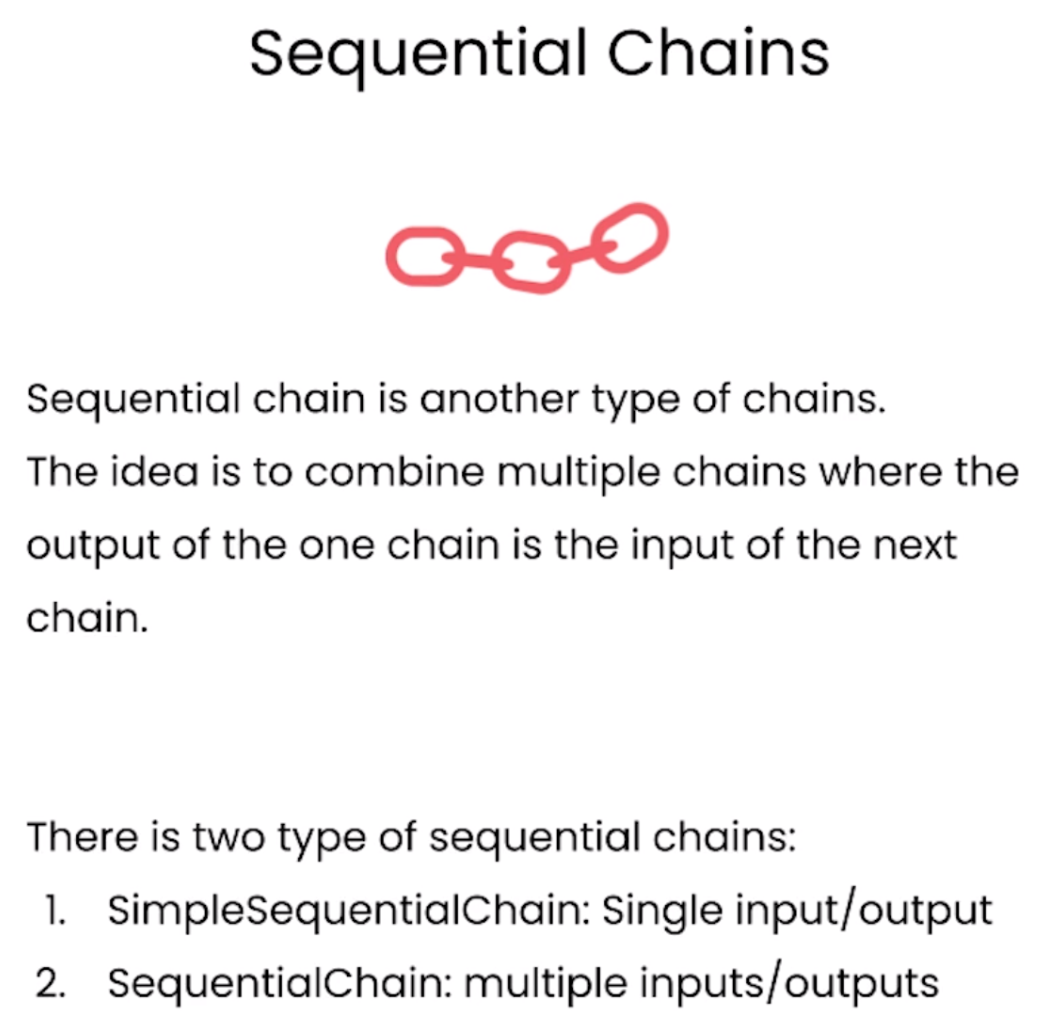

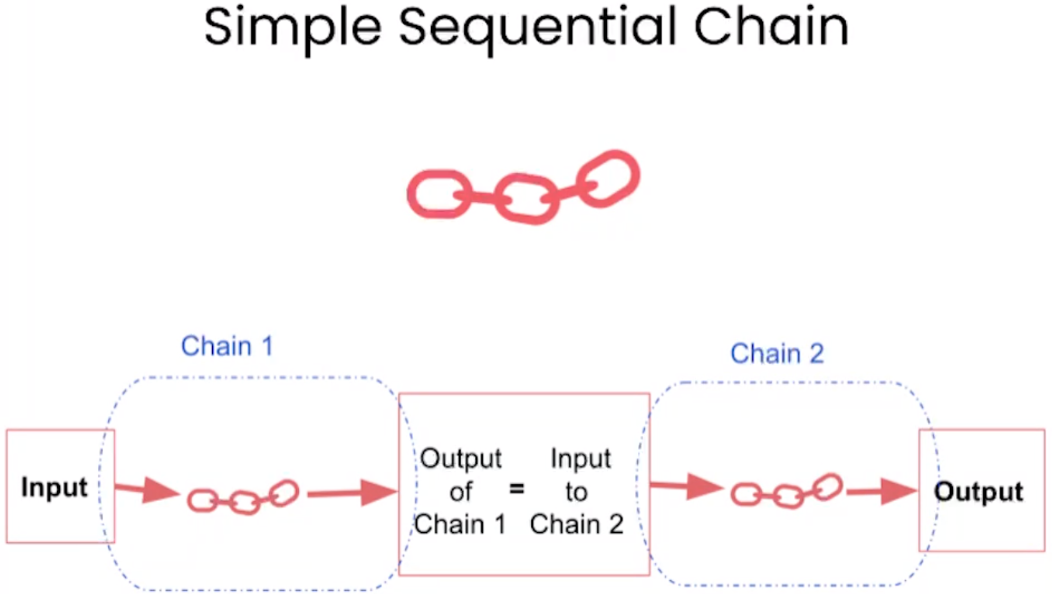
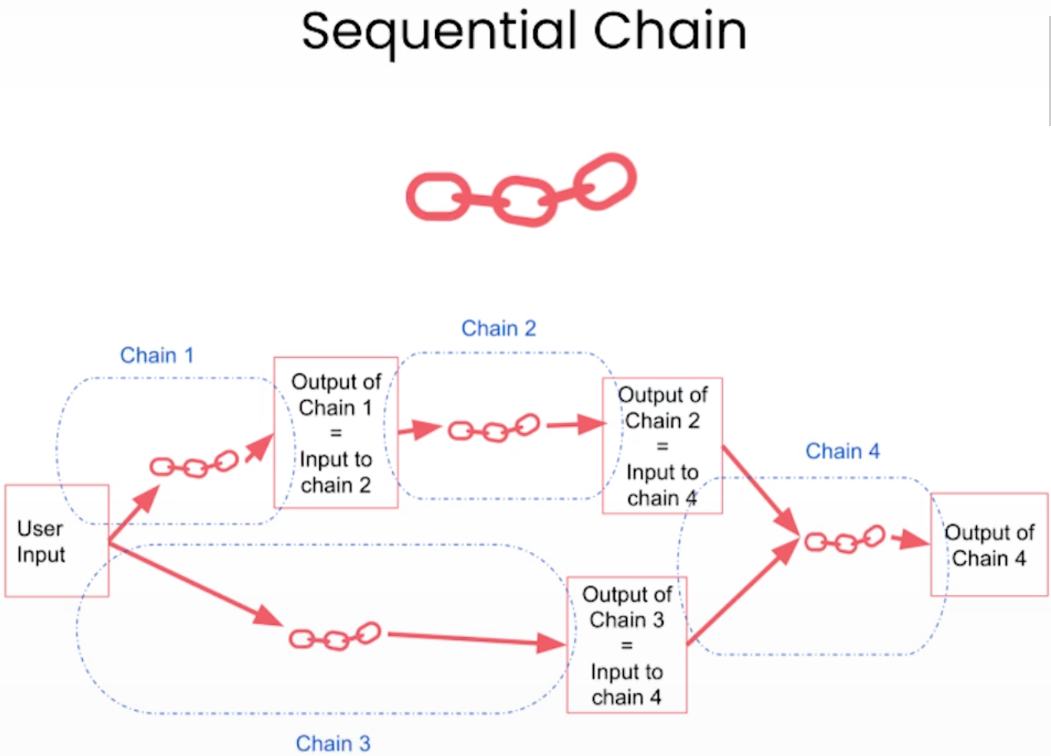
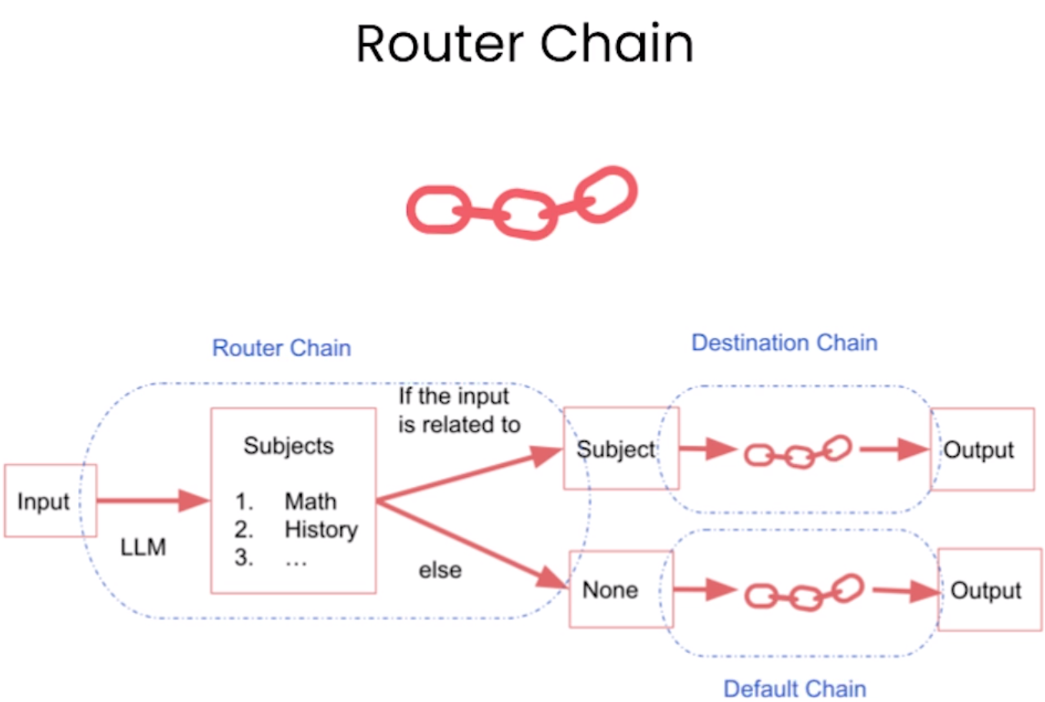
